## Install libraries needed

In [ ]:
## install some new libraries needed in this project

#! pip install cv2
#! pip install keras
#! pip install tensorflow
#pip install keras.applications

## Import libraries

In [9]:
## import the libraries we used in this project

import pickle
import random
import numpy as np 
import os, os.path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers,optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model, load_model, Sequential

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16   
from keras.applications.vgg19 import VGG19
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, InputLayer,Activation ,Dropout,BatchNormalization, GlobalAveragePooling2D

## Reading images dataset 

In [10]:
## reading path of the images and put it in DataFrame with their class

folders=['beauty','family','fashion','fitness','food']

def df_fol():
    df_all_images=pd.DataFrame()
    df_images= pd.DataFrame()
    for folder in folders:
        list_images_path= []
        for dirname, _, filenames in os.walk(f'Dataset/{folder}/'):
            for filename in filenames:
                list_images_path.append(os.path.join(dirname, filename))
        df_images["Images_Path"] = list_images_path
        df_images["Class"] = (f"{folder}")
        df_all_images = pd.concat([df_all_images, df_images], ignore_index=True)

    return df_all_images

In [11]:
# put a name for the dataframe and shuffle it

df=df_fol().sample(frac=1).reset_index(drop=True)
df

,Images_Path,Class
0,Dataset/fitness/annaturkington.jpg,fitness
1,Dataset/fashion/julia.haupt.jpg,fashion
2,Dataset/fashion/_ambergordon_.jpg,fashion
3,Dataset/beauty/trinaduhra.jpg,beauty
4,Dataset/food/vodkaprgirl.jpg,food
...,...,...
3765,Dataset/fitness/lapesi.jpg,fitness
3766,Dataset/food/ohsweetbasil.jpg,food
3767,Dataset/food/mylifeastheresaa.jpg,food
3768,Dataset/family/brittanyamonroe.jpg,family


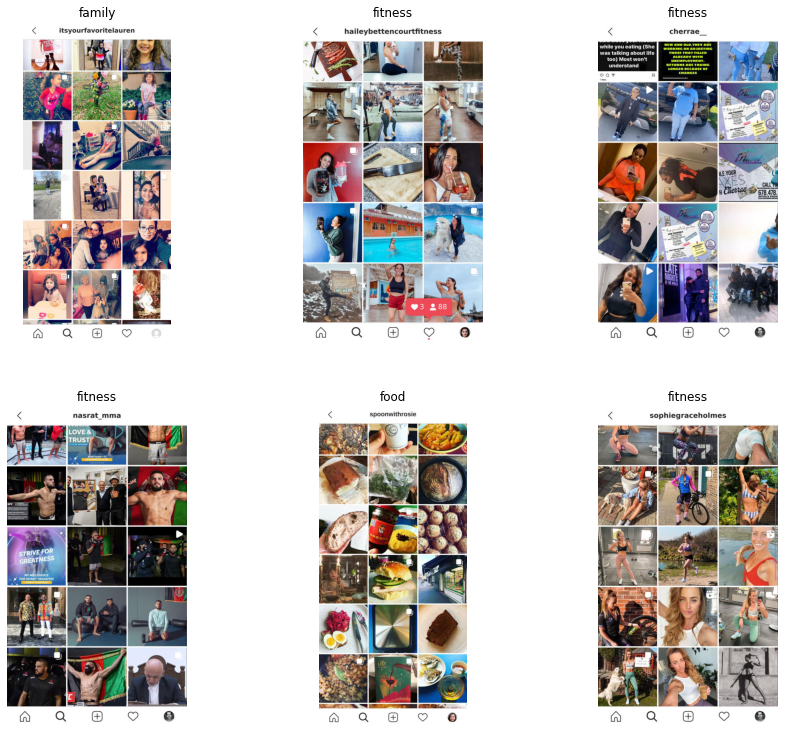

In [12]:
## show an examples of the images

plt.figure(figsize=(15, 20))
ran_num = []
for i in range(0,6):
    n = random.randint(0,len(df['Images_Path']))
    ran_num.append(n)
for i in range(6):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(df['Images_Path'][ran_num[i]]))
    plt.title(df['Class'][ran_num[i]])
    plt.axis("off")

Text(0.5, 1.0, 'Distribution the images in the categories ')

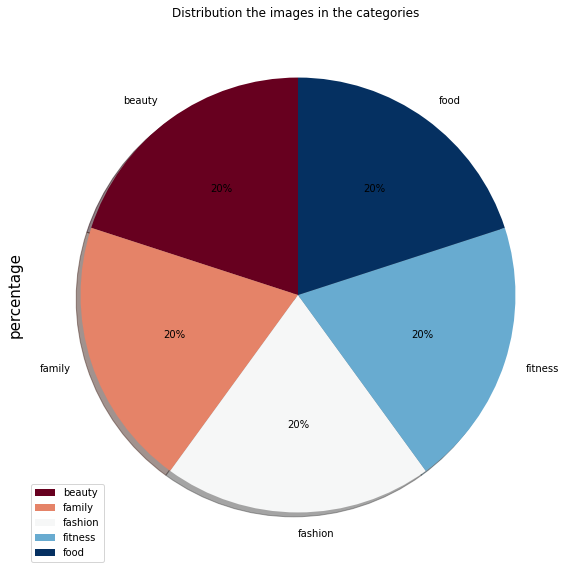

In [13]:
## distribution the images in the categories

df_new=((df.groupby(['Class']).agg(['count'])/3770)*100)
df_new.plot(kind='pie', subplots=True, shadow = True,startangle=90,figsize=(10,10),cmap="RdBu",autopct='%1.0f%%')
plt.ylabel("percentage",fontsize=15)
plt.title("Distribution the images in the categories ")

## Prepare images and labels

In [14]:
## load the images and convert it to numbers of daimantion

images = []
for img_path in df['Images_Path']:
    img = image.load_img(img_path, target_size=(200, 150))# target_size it a diff if i put number from my mind
    x = image.img_to_array(img)
    images.append(x)
    
## conver the images to array and reference it to 'X'   
X = np.array(images, dtype="float")/255

In [15]:
## convert the labels to numericals class and reference it to 'Y'  

labels = [int(df['Class'][w].replace('beauty', "0").replace("family",'1').replace('fashion', "0").replace("fitness",'3').replace('food', "4")) for w in range(len(df['Class']))]
#Y = to_categorical(labels, num_classes = 5)
y = np.array(labels)# for logestic

In [ ]:
## put x and y in pickles
'''
open_file = open("X.txt", "wb")
pickle.dump(X, open_file)
open_file.close()



open_file = open("Y.txt", "wb")
pickle.dump(Y, open_file)
open_file.close()
'''

## Split  Dataset into train, val, test

In [16]:
## chake the shape of x and y

print(X.shape)
print(y.shape)

(3770, 200, 150, 3)
(3770,)


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .1, random_state = 42)

In [45]:
y_train_cat=to_categorical(y_train, num_classes = 5)
y_val_cat=to_categorical(y_val, num_classes = 5)
y_test_cat=to_categorical(y_test, num_classes = 5)

## Generate Data 

In [19]:

train_datagen = ImageDataGenerator(  width_shift_range=[-200,200] ## Shifting
                                    ,horizontal_flip=True, vertical_flip=True ## Flipping
                                    ,rotation_range=90, fill_mode='nearest' ## Rotation
                                    ,zoom_range=0.2)


datagen = ImageDataGenerator()


train_generator = train_datagen.flow(X_train,y_train_cat)

val_generator = datagen.flow(X_val,y_val_cat)

test_generator = datagen.flow(X_test,y_test_cat)


### Evaluation function

In [21]:
# build funcation for evaluation 

def Get_accuracy(model):

    train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=1)
    test_loss, test_acc = model.evaluate(X_val,y_val_cat, verbose=1)

    print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
    print(f'Validation Accuracy:\t{test_acc * 100}\nValidation Loss:\t{test_loss}\n')
    print('Train/Validation Diff:\t', np.abs(train_acc - test_acc) * 100)

# Models

### Model 1: Baseline Logistic Regression

In [24]:
## chake the shape of x and y

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3053, 200, 150, 3)
(340, 200, 150, 3)
(377, 200, 150, 3)


In [25]:
## Reshape x
X_train_re= X_train.reshape(3053, 200*150*3)
X_val_re= X_val.reshape(340, 200*150*3)
X_test_re= X_test.reshape(377, 200*150*3)

In [103]:
#[100,10,0.1,0.001,0.00001]
LR = LogisticRegression(C=0.000001,multi_class = 'multinomial', solver = 'lbfgs')
LR.fit(X_train_re,y_train)

LogisticRegression(C=1e-06, multi_class='multinomial')

In [104]:
print('The accuracy for training : ',LR.score(X_train_re,y_train))
print('The accuracy for validation: ',LR.score(X_val_re,y_val))

The accuracy for training :  0.41467409105797576
The accuracy for validation:  0.4


### Model 2:  Neural Network Models

In [23]:
early_stopping = EarlyStopping( monitor='val_loss',
                                patience=1, 
                                mode='min')

In [202]:
## model 1

#np.random.seed(1000)

model_nn1= Sequential()

model_nn1.add(InputLayer(input_shape=(200,150,3)))


model_nn1.add(Dense(25,activation='relu'))

model_nn1.add(Flatten())
model_nn1.add(Dense(5, activation = 'softmax'))  

model_nn1.compile(  optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_nn1.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 200, 150, 25)      100       
                                                                 
 flatten_24 (Flatten)        (None, 750000)            0         
                                                                 
 dense_87 (Dense)            (None, 5)                 3750005   
                                                                 
Total params: 3,750,105
Trainable params: 3,750,105
Non-trainable params: 0
_________________________________________________________________


In [127]:
model_nn1.fit(    X_train,y_train_cat,
                  validation_data=(X_val, y_val_cat),
                  epochs=30,
                  batch_size=32,
                  callbacks=early_stopping)

Epoch 1/30
96/96 [==============================] - 31s 283ms/step - loss: 15.3769 - accuracy: 0.5447 - val_loss: 2.6366 - val_accuracy: 0.6824
Epoch 2/30
96/96 [==============================] - 24s 248ms/step - loss: 1.2748 - accuracy: 0.8156 - val_loss: 4.0448 - val_accuracy: 0.6912


In [128]:
Get_accuracy(model_nn1)

11/11 [==============================] - 1s 107ms/step - loss: 4.0448 - accuracy: 0.6912


Training Accuracy:	74.32034015655518
Training Loss:		2.7798566818237305

Validation Accuracy:	69.11764740943909
Validation Loss:	4.044783592224121

Train/Validation Diff:	 5.202692747116089


In [204]:
model_nn1.fit_generator(    train_generator,
                            epochs=30, 
                            validation_data=val_generator,
                            callbacks=early_stopping)

/var/folders/yp/mrrrdhms149_ntzbn52gyyx00000gr/T/ipykernel_402/1853296547.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_nn1.fit_generator(    train_generator,


Epoch 1/30
96/96 [==============================] - 52s 546ms/step - loss: 5.2886 - accuracy: 0.3013 - val_loss: 2.3366 - val_accuracy: 0.5088
Epoch 2/30
96/96 [==============================] - 45s 460ms/step - loss: 2.0998 - accuracy: 0.3334 - val_loss: 1.3821 - val_accuracy: 0.4235
Epoch 3/30
96/96 [==============================] - 44s 458ms/step - loss: 2.0217 - accuracy: 0.3122 - val_loss: 1.3340 - val_accuracy: 0.4735
Epoch 4/30
96/96 [==============================] - 41s 424ms/step - loss: 1.6229 - accuracy: 0.3459 - val_loss: 1.1900 - val_accuracy: 0.5324
Epoch 5/30
96/96 [==============================] - 42s 437ms/step - loss: 1.5530 - accuracy: 0.3505 - val_loss: 1.4045 - val_accuracy: 0.4118


In [205]:
Get_accuracy(model_nn1)

11/11 [==============================] - 1s 86ms/step - loss: 1.4045 - accuracy: 0.4118


Training Accuracy:	46.05306386947632
Training Loss:		1.3532698154449463

Validation Accuracy:	41.17647111415863
Validation Loss:	1.4045029878616333

Train/Validation Diff:	 4.876592755317688


In [206]:
## model 2 
model_nn2 = Sequential()


model_nn2.add(InputLayer(input_shape=(200,150,3)))


model_nn2.add(Dense(125,activation='tanh')) 
model_nn2.add(Dropout(rate=.5))

model_nn2.add(Dense(25,activation='tanh'))   
model_nn2.add(Dropout(rate=.5))

model_nn2.add(Flatten())
model_nn2.add(Dense(5, activation = 'softmax'))  

model_nn2.compile(  keras.optimizers.Adam(lr=0.001),
                    loss="categorical_crossentropy", 
                    metrics=['accuracy'])

model_nn2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 200, 150, 125)     500       
                                                                 
 dropout_62 (Dropout)        (None, 200, 150, 125)     0         
                                                                 
 dense_89 (Dense)            (None, 200, 150, 25)      3150      
                                                                 
 dropout_63 (Dropout)        (None, 200, 150, 25)      0         
                                                                 
 flatten_25 (Flatten)        (None, 750000)            0         
                                                                 
 dense_90 (Dense)            (None, 5)                 3750005   
                                                                 
Total params: 3,753,655
Trainable params: 3,753,655
N

In [207]:
model_nn2.fit(    X_train,y_train_cat,
                  validation_data=(X_val, y_val_cat),
                  epochs=30,
                  callbacks=early_stopping)

Epoch 1/30
96/96 [==============================] - 259s 3s/step - loss: 3.1485 - accuracy: 0.5876 - val_loss: 0.5027 - val_accuracy: 0.8088
Epoch 2/30
96/96 [==============================] - 216s 2s/step - loss: 0.8755 - accuracy: 0.7498 - val_loss: 0.5968 - val_accuracy: 0.8235


In [208]:
Get_accuracy(model_nn2)

11/11 [==============================] - 5s 437ms/step - loss: 0.5968 - accuracy: 0.8235


Training Accuracy:	88.11005353927612
Training Loss:		0.36675843596458435

Validation Accuracy:	82.35294222831726
Validation Loss:	0.5967743992805481

Train/Validation Diff:	 5.757111310958862


In [226]:
model_nn2.fit_generator(    train_generator,
                            epochs=30, 
                            validation_data=val_generator,
                            callbacks=early_stopping)

/var/folders/yp/mrrrdhms149_ntzbn52gyyx00000gr/T/ipykernel_402/1438831522.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_nn2.fit_generator(    train_generator,


Epoch 1/30
96/96 [==============================] - 229s 2s/step - loss: 3.8109 - accuracy: 0.2948 - val_loss: 0.9928 - val_accuracy: 0.6735
Epoch 2/30
96/96 [==============================] - 210s 2s/step - loss: 2.7193 - accuracy: 0.2918 - val_loss: 0.8516 - val_accuracy: 0.6471
Epoch 3/30
96/96 [==============================] - 215s 2s/step - loss: 1.8077 - accuracy: 0.3108 - val_loss: 1.0073 - val_accuracy: 0.5265


In [227]:
Get_accuracy(model_nn2)

11/11 [==============================] - 5s 409ms/step - loss: 1.0073 - accuracy: 0.5265


Training Accuracy:	64.78873491287231
Training Loss:		0.829592227935791

Validation Accuracy:	52.64706015586853
Validation Loss:	1.007347583770752

Train/Validation Diff:	 12.141674757003784


## Model 3: Convolutional Neural Networks ( CNN )

In [230]:
## try 1
  

model_cnn1 = Sequential()

model_cnn1.add(InputLayer(input_shape=(200,150,3)))

model_cnn1.add(Conv2D(filters=5, kernel_size=3, activation='tanh', padding='same'))
model_cnn1.add(MaxPooling2D())

model_cnn1.add(Conv2D(filters=10, kernel_size=3, activation='tanh', padding='same'))
model_cnn1.add(MaxPooling2D())

model_cnn1.add(Conv2D(filters=15, kernel_size=3, activation='tanh', padding='same'))

model_cnn1.add(GlobalAveragePooling2D())
model_cnn1.add(Flatten())




model_cnn1.add(Dense(125, activation='tanh'))
model_cnn1.add(Dropout(rate=.5, seed=123))

model_cnn1.add(Dense(25, activation='tanh'))
model_cnn1.add(Dropout(rate=.5, seed=123))

model_cnn1.add(Dense(5, activation='softmax'))  

model_cnn1.compile( keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 200, 150, 5)       140       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 100, 75, 5)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 100, 75, 10)       460       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 50, 37, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 50, 37, 15)        1365      
                                                                 
 global_average_pooling2d (G  (None, 15)             

In [47]:
model_cnn1.fit(  X_train, y_train_cat,  
                 validation_data=(X_val, y_val_cat),
                 epochs=30,
                 batch_size=32,
                 callbacks=early_stopping) 

Epoch 1/30
96/96 [==============================] - 55s 548ms/step - loss: 1.4753 - accuracy: 0.3564 - val_loss: 1.3539 - val_accuracy: 0.3971
Epoch 2/30
96/96 [==============================] - 49s 514ms/step - loss: 1.3029 - accuracy: 0.4399 - val_loss: 1.1599 - val_accuracy: 0.4824
Epoch 3/30
96/96 [==============================] - 46s 478ms/step - loss: 1.1794 - accuracy: 0.4805 - val_loss: 1.1032 - val_accuracy: 0.5147
Epoch 4/30
96/96 [==============================] - 41s 422ms/step - loss: 1.1289 - accuracy: 0.4975 - val_loss: 1.0544 - val_accuracy: 0.5294
Epoch 5/30
96/96 [==============================] - 41s 427ms/step - loss: 1.0703 - accuracy: 0.5208 - val_loss: 1.0155 - val_accuracy: 0.5353
Epoch 6/30
96/96 [==============================] - 41s 430ms/step - loss: 1.0334 - accuracy: 0.5319 - val_loss: 1.0303 - val_accuracy: 0.5265


In [48]:
Get_accuracy(model_cnn1)

11/11 [==============================] - 2s 164ms/step - loss: 1.0303 - accuracy: 0.5265


Training Accuracy:	53.12806963920593
Training Loss:		1.0258296728134155

Validation Accuracy:	52.64706015586853
Validation Loss:	1.0302690267562866

Train/Validation Diff:	 0.48100948333740234


In [231]:
model_cnn1.fit(  train_generator,
                 validation_data=(val_generator),
                 epochs=30,
                 batch_size=32,
                 callbacks=early_stopping)

Epoch 1/30
96/96 [==============================] - 53s 529ms/step - loss: 1.4666 - accuracy: 0.3416 - val_loss: 1.3558 - val_accuracy: 0.4382
Epoch 2/30
96/96 [==============================] - 41s 430ms/step - loss: 1.4106 - accuracy: 0.3521 - val_loss: 1.3646 - val_accuracy: 0.4382


In [232]:
Get_accuracy(model_cnn1)

11/11 [==============================] - 1s 91ms/step - loss: 1.3646 - accuracy: 0.4382


Training Accuracy:	39.240092039108276
Training Loss:		1.3839927911758423

Validation Accuracy:	43.82352828979492
Validation Loss:	1.364607334136963

Train/Validation Diff:	 4.5834362506866455


In [233]:
## try 2

model_cnn2 = Sequential()

model_cnn2.add(InputLayer(input_shape=(200,150,3)))

model_cnn2.add(Conv2D(filters=5, kernel_size=3, activation='tanh', padding='same'))
model_cnn2.add(MaxPooling2D())

model_cnn2.add(Conv2D(filters=10, kernel_size=3, activation='tanh', padding='same'))
model_cnn2.add(MaxPooling2D())

model_cnn2.add(Conv2D(filters=15, kernel_size=3, activation='tanh', padding='same'))

model_cnn2.add(GlobalAveragePooling2D())
model_cnn2.add(Flatten())


#model_cnn2.add(Dense(1000, activation='tanh'))
#model_cnn2.add(Dense(500, activation='tanh'))

model_cnn2.add(Dense(250, activation='tanh'))
model_cnn2.add(Dropout(rate=.5, seed=123))

model_cnn2.add(Dense(125, activation='tanh'))
model_cnn2.add(Dropout(rate=.5, seed=123))

model_cnn2.add(Dense(25, activation='tanh'))
model_cnn2.add(Dropout(rate=.5, seed=123))

model_cnn2.add(Dense(5, activation='softmax'))  

model_cnn2.compile( keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 200, 150, 5)       140       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 100, 75, 5)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 100, 75, 10)       460       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 50, 37, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 50, 37, 15)        1365      
                                                                 
 global_average_pooling2d_1   (None, 15)             

In [76]:
model_cnn2.fit( X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=32,
                callbacks=early_stopping) 

Epoch 1/30
96/96 [==============================] - 62s 603ms/step - loss: 1.4220 - accuracy: 0.3560 - val_loss: 1.3147 - val_accuracy: 0.4029
Epoch 2/30
96/96 [==============================] - 44s 458ms/step - loss: 1.2625 - accuracy: 0.4314 - val_loss: 1.2719 - val_accuracy: 0.4118
Epoch 3/30
96/96 [==============================] - 43s 447ms/step - loss: 1.1823 - accuracy: 0.4776 - val_loss: 1.0876 - val_accuracy: 0.5118
Epoch 4/30
96/96 [==============================] - 43s 446ms/step - loss: 1.1208 - accuracy: 0.5025 - val_loss: 1.0209 - val_accuracy: 0.5324
Epoch 5/30
96/96 [==============================] - 43s 453ms/step - loss: 1.0867 - accuracy: 0.5126 - val_loss: 1.0198 - val_accuracy: 0.5235
Epoch 6/30
96/96 [==============================] - 42s 438ms/step - loss: 1.0255 - accuracy: 0.5437 - val_loss: 1.0497 - val_accuracy: 0.5353


In [77]:
Get_accuracy(model_cnn2)

11/11 [==============================] - 2s 162ms/step - loss: 1.0497 - accuracy: 0.5353


Training Accuracy:	55.81395626068115
Training Loss:		1.0197620391845703

Validation Accuracy:	53.52941155433655
Validation Loss:	1.0496852397918701

Train/Validation Diff:	 2.2845447063446045


In [234]:
model_cnn2.fit(  train_generator,
                 validation_data=(val_generator),
                 epochs=30,
                 batch_size=32,
                 callbacks=early_stopping)

Epoch 1/30
96/96 [==============================] - 52s 515ms/step - loss: 1.4489 - accuracy: 0.3515 - val_loss: 1.3355 - val_accuracy: 0.4382
Epoch 2/30
96/96 [==============================] - 41s 429ms/step - loss: 1.4070 - accuracy: 0.3672 - val_loss: 1.3217 - val_accuracy: 0.4382
Epoch 3/30
96/96 [==============================] - 44s 461ms/step - loss: 1.3857 - accuracy: 0.3675 - val_loss: 1.3133 - val_accuracy: 0.4382
Epoch 4/30
96/96 [==============================] - 41s 426ms/step - loss: 1.3812 - accuracy: 0.3757 - val_loss: 1.3188 - val_accuracy: 0.4382


In [235]:
Get_accuracy(model_cnn2)

11/11 [==============================] - 1s 81ms/step - loss: 1.3188 - accuracy: 0.4382


Training Accuracy:	39.240092039108276
Training Loss:		1.3431651592254639

Validation Accuracy:	43.82352828979492
Validation Loss:	1.3187936544418335

Train/Validation Diff:	 4.5834362506866455


In [236]:
## try 3

model_cnn3 = Sequential()

model_cnn3.add(InputLayer(input_shape=(200,150,3)))

model_cnn3.add(Conv2D(filters=30, kernel_size=3, activation='tanh', padding='same'))
model_cnn3.add(MaxPooling2D())

model_cnn3.add(Conv2D(filters=60, kernel_size=3, activation='tanh', padding='same'))
model_cnn3.add(MaxPooling2D())

model_cnn3.add(Conv2D(filters=90, kernel_size=3, activation='tanh', padding='same'))
model_cnn3.add(MaxPooling2D())

model_cnn3.add(GlobalAveragePooling2D())
model_cnn3.add(Flatten())


model_cnn3.add(Dense(125, activation='tanh'))
model_cnn3.add(Dropout(rate=.05, seed=123))

model_cnn3.add(Dense(25, activation='tanh'))
model_cnn3.add(Dropout(rate=.05, seed=123))

model_cnn3.add(Dense(5, activation='softmax'))  

model_cnn3.compile( keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn3.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 200, 150, 30)      840       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 100, 75, 30)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 100, 75, 60)       16260     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 50, 37, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 50, 37, 90)        48690     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 25, 18, 90)     

In [83]:
model_cnn3.fit( X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=32,
                callbacks=early_stopping) 

Epoch 1/30
96/96 [==============================] - 98s 992ms/step - loss: 1.2768 - accuracy: 0.4451 - val_loss: 1.2378 - val_accuracy: 0.4529
Epoch 2/30
96/96 [==============================] - 90s 932ms/step - loss: 1.1211 - accuracy: 0.5008 - val_loss: 1.0196 - val_accuracy: 0.5324
Epoch 3/30
96/96 [==============================] - 100s 1s/step - loss: 0.9903 - accuracy: 0.5463 - val_loss: 0.9632 - val_accuracy: 0.5853
Epoch 4/30
96/96 [==============================] - 107s 1s/step - loss: 0.9215 - accuracy: 0.5912 - val_loss: 0.8926 - val_accuracy: 0.5912
Epoch 5/30
96/96 [==============================] - 104s 1s/step - loss: 0.7774 - accuracy: 0.6662 - val_loss: 0.6997 - val_accuracy: 0.7059
Epoch 6/30
96/96 [==============================] - 121s 1s/step - loss: 0.6585 - accuracy: 0.7242 - val_loss: 0.6882 - val_accuracy: 0.7176
Epoch 7/30
96/96 [==============================] - 173s 2s/step - loss: 0.6095 - accuracy: 0.7478 - val_loss: 0.9001 - val_accuracy: 0.6412


In [84]:
Get_accuracy(model_cnn3)

11/11 [==============================] - 6s 543ms/step - loss: 0.9001 - accuracy: 0.6412


Training Accuracy:	64.13363814353943
Training Loss:		0.8559359908103943

Validation Accuracy:	64.11764621734619
Validation Loss:	0.9001111388206482

Train/Validation Diff:	 0.015991926193237305


In [237]:
model_cnn3.fit(  train_generator,
                 validation_data=(val_generator),
                 epochs=30,
                 batch_size=32,
                 callbacks=early_stopping)

Epoch 1/30
96/96 [==============================] - 103s 1s/step - loss: 1.3892 - accuracy: 0.3603 - val_loss: 1.3189 - val_accuracy: 0.4382
Epoch 2/30
96/96 [==============================] - 93s 966ms/step - loss: 1.3652 - accuracy: 0.3741 - val_loss: 1.3156 - val_accuracy: 0.4382
Epoch 3/30
96/96 [==============================] - 93s 965ms/step - loss: 1.3651 - accuracy: 0.3741 - val_loss: 1.3231 - val_accuracy: 0.4382


In [238]:
Get_accuracy(model_cnn3)

11/11 [==============================] - 3s 225ms/step - loss: 1.3231 - accuracy: 0.4382


Training Accuracy:	39.27284777164459
Training Loss:		1.339937448501587

Validation Accuracy:	43.82352828979492
Validation Loss:	1.3231050968170166

Train/Validation Diff:	 4.55068051815033


In [88]:
## try 4

model_cnn4 = Sequential()

model_cnn4.add(InputLayer(input_shape=(200,150,3)))

model_cnn4.add(Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'))
model_cnn4.add(MaxPooling2D())

model_cnn4.add(Conv2D(filters=60, kernel_size=3, activation='tanh', padding='valid'))
model_cnn4.add(MaxPooling2D())

model_cnn4.add(Conv2D(filters=90, kernel_size=3, activation='tanh', padding='valid'))

model_cnn4.add(GlobalAveragePooling2D())
model_cnn4.add(Flatten())




model_cnn4.add(Dense(250, activation='tanh'))
model_cnn4.add(Dropout(rate=.05, seed=123))

model_cnn4.add(Dense(125, activation='tanh'))
model_cnn4.add(Dropout(rate=.05, seed=123))

model_cnn4.add(Dense(25, activation='tanh'))
model_cnn4.add(Dropout(rate=.05, seed=123))

model_cnn4.add(Dense(5, activation='softmax'))  

model_cnn4.compile( keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn4.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 198, 148, 30)      840       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 99, 74, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 97, 72, 60)        16260     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 48, 36, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 46, 34, 90)        48690     
                                                                 
 global_average_pooling2d_20  (None, 90)             

In [89]:
model_cnn4.fit( X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=32,
                callbacks=early_stopping) 

Epoch 1/30
96/96 [==============================] - 163s 2s/step - loss: 1.2195 - accuracy: 0.4546 - val_loss: 1.0586 - val_accuracy: 0.5118
Epoch 2/30
96/96 [==============================] - 148s 2s/step - loss: 1.0857 - accuracy: 0.5021 - val_loss: 1.0445 - val_accuracy: 0.5176
Epoch 3/30
96/96 [==============================] - 149s 2s/step - loss: 0.9560 - accuracy: 0.5706 - val_loss: 0.9203 - val_accuracy: 0.5676
Epoch 4/30
96/96 [==============================] - 152s 2s/step - loss: 0.8766 - accuracy: 0.6096 - val_loss: 0.7568 - val_accuracy: 0.6353
Epoch 5/30
96/96 [==============================] - 150s 2s/step - loss: 0.8009 - accuracy: 0.6482 - val_loss: 0.7286 - val_accuracy: 0.7294
Epoch 6/30
96/96 [==============================] - 146s 2s/step - loss: 0.6849 - accuracy: 0.7180 - val_loss: 0.6863 - val_accuracy: 0.7324
Epoch 7/30
96/96 [==============================] - 157s 2s/step - loss: 0.6333 - accuracy: 0.7419 - val_loss: 0.6298 - val_accuracy: 0.7382
Epoch 8/30
96

In [90]:
Get_accuracy(model_cnn4)

11/11 [==============================] - 5s 412ms/step - loss: 0.6058 - accuracy: 0.7529


Training Accuracy:	76.2528657913208
Training Loss:		0.5805830955505371

Validation Accuracy:	75.29411911964417
Validation Loss:	0.605777382850647

Train/Validation Diff:	 0.9587466716766357


In [121]:
## try 5

model_cnn5 = Sequential()

model_cnn5.add(InputLayer(input_shape=(200,150,3)))

model_cnn5.add(Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'))
model_cnn5.add(MaxPooling2D())

model_cnn5.add(Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'))
model_cnn5.add(MaxPooling2D())

model_cnn5.add(Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'))
model_cnn5.add(MaxPooling2D())

model_cnn5.add(GlobalAveragePooling2D())
model_cnn5.add(Flatten())


model_cnn5.add(Dense(500, activation='tanh'))
model_cnn5.add(Dropout(rate=.5, seed=123))

model_cnn5.add(Dense(250, activation='tanh'))
model_cnn5.add(Dropout(rate=.5, seed=123))

model_cnn5.add(Dense(125, activation='tanh'))
model_cnn5.add(Dropout(rate=.5, seed=123))

model_cnn5.add(Dense(25, activation='tanh'))
model_cnn5.add(Dropout(rate=.5, seed=123))

model_cnn5.add(Dense(5, activation='softmax'))  

model_cnn5.compile( keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn5.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 198, 148, 30)      840       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 99, 74, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 97, 72, 30)        8130      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 48, 36, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 46, 34, 30)        8130      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 23, 17, 30)     

/Users/meshael/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [124]:
model_cnn5.fit(   X_train,y_train_cat, 
                  validation_data=(X_val, y_val_cat),
                  epochs=30,
                  batch_size=32,
                  callbacks=early_stopping)

Epoch 1/30
96/96 [==============================] - 109s 1s/step - loss: 0.9739 - accuracy: 0.5771 - val_loss: 0.9899 - val_accuracy: 0.6353
Epoch 2/30
96/96 [==============================] - 102s 1s/step - loss: 0.9015 - accuracy: 0.6191 - val_loss: 0.7100 - val_accuracy: 0.7176
Epoch 3/30
96/96 [==============================] - 104s 1s/step - loss: 0.7588 - accuracy: 0.7023 - val_loss: 0.6831 - val_accuracy: 0.7235
Epoch 4/30
96/96 [==============================] - 101s 1s/step - loss: 0.7335 - accuracy: 0.7209 - val_loss: 0.6423 - val_accuracy: 0.7441
Epoch 5/30
96/96 [==============================] - 101s 1s/step - loss: 0.6806 - accuracy: 0.7363 - val_loss: 0.5704 - val_accuracy: 0.7412
Epoch 6/30
96/96 [==============================] - 105s 1s/step - loss: 0.7170 - accuracy: 0.7275 - val_loss: 0.5704 - val_accuracy: 0.7324
Epoch 7/30
96/96 [==============================] - 118s 1s/step - loss: 0.6746 - accuracy: 0.7481 - val_loss: 0.5691 - val_accuracy: 0.7559
Epoch 8/30
96

In [125]:
Get_accuracy(model_cnn5)

11/11 [==============================] - 3s 294ms/step - loss: 0.6090 - accuracy: 0.7529


Training Accuracy:	77.39927768707275
Training Loss:		0.5453985333442688

Validation Accuracy:	75.29411911964417
Validation Loss:	0.6090368032455444

Train/Validation Diff:	 2.105158567428589


## Transfer Learning 

In [51]:
### vgg16 model
## try 1

base = VGG16(weights='imagenet', include_top=False, input_shape=(200, 150, 3))

for layer in base.layers:
    layer.trainable = False  

model_tr1 = Sequential(
                        [InputLayer(input_shape=(200,150,3)),
                         base,
                         Conv2D(filters=30, kernel_size=3, activation='tanh', padding='same'),
                         MaxPooling2D(),

                         Flatten(),
                         Dense(125, activation='tanh'),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(25, activation='tanh'),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(5, activation='softmax')]
                       )

model_tr1.compile(  keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_tr1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 4, 512)         14714688  
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 4, 30)          138270    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 2, 30)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 180)               0         
                                                                 
 dense_32 (Dense)            (None, 125)               22625     
                                                                 
 dropout_22 (Dropout)        (None, 125)               0         
                                                     

In [52]:
model_tr1.fit(  X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=50,
                callbacks=[early_stopping]) 

Epoch 1/30
62/62 [==============================] - 1008s 16s/step - loss: 0.9735 - accuracy: 0.5948 - val_loss: 0.6486 - val_accuracy: 0.7324
Epoch 2/30
62/62 [==============================] - 938s 15s/step - loss: 0.5764 - accuracy: 0.7783 - val_loss: 0.6162 - val_accuracy: 0.7588
Epoch 3/30
62/62 [==============================] - 958s 15s/step - loss: 0.4302 - accuracy: 0.8415 - val_loss: 0.5947 - val_accuracy: 0.7706
Epoch 4/30
62/62 [==============================] - 934s 15s/step - loss: 0.4072 - accuracy: 0.8526 - val_loss: 0.4946 - val_accuracy: 0.8059
Epoch 5/30
62/62 [==============================] - 932s 15s/step - loss: 0.2468 - accuracy: 0.9175 - val_loss: 0.5373 - val_accuracy: 0.8235


In [62]:
Get_accuracy(model_tr1)

11/11 [==============================] - 45s 4s/step - loss: 0.5373 - accuracy: 0.8235


Training Accuracy:	93.84212493896484
Training Loss:		0.18665200471878052

Validation Accuracy:	82.35294222831726
Validation Loss:	0.5372583270072937

Train/Validation Diff:	 11.489182710647583


In [49]:
## VGG19 model
## try 1

base2 = VGG19(weights='imagenet', include_top=False, input_shape=(200, 150, 3))

for layer in base2.layers:
    layer.trainable = False  

model_tr2 = Sequential( [InputLayer(input_shape=(200,150,3)),  
                         base2,
                         Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'),
                         MaxPooling2D(),
                         
                         Flatten(),
                         Dense(250, activation='tanh'),
                         Dropout(rate=.25, seed=123),

                         Dense(125, activation='tanh'),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(25, activation='tanh'),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(5, activation='softmax')] )

model_tr2.compile(   keras.optimizers.Adam(lr=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_tr2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 4, 512)         20024384  
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 2, 30)          138270    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 1, 30)         0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 60)                0         
                                                                 
 dense_30 (Dense)            (None, 250)               15250     
                                                                 
 dropout_22 (Dropout)        (None, 250)               0         
                                                      

In [50]:
model_tr2.fit(  X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=32,
                callbacks= early_stopping)

Epoch 1/30
96/96 [==============================] - 585s 6s/step - loss: 0.9885 - accuracy: 0.5732 - val_loss: 0.7540 - val_accuracy: 0.7206
Epoch 2/30
96/96 [==============================] - 583s 6s/step - loss: 0.6492 - accuracy: 0.7422 - val_loss: 0.5249 - val_accuracy: 0.8059
Epoch 3/30
96/96 [==============================] - 582s 6s/step - loss: 0.4634 - accuracy: 0.8254 - val_loss: 0.5473 - val_accuracy: 0.8029


In [51]:
Get_accuracy(model_tr2)

11/11 [==============================] - 57s 5s/step - loss: 0.5473 - accuracy: 0.8029


Training Accuracy:	84.83458757400513
Training Loss:		0.38648679852485657

Validation Accuracy:	80.29412031173706
Validation Loss:	0.547345757484436

Train/Validation Diff:	 4.540467262268066


In [55]:
## VGG19 model
## try 3

base2 = VGG19(weights='imagenet', include_top=False, input_shape=(200, 150, 3))

for layer in base2.layers:
    layer.trainable = False  

model_tr22 = Sequential( [InputLayer(input_shape=(200,150,3)),  
                         base2,
                         Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'),
                         MaxPooling2D(),
                         
                         Flatten(),
                         Dense(250, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.001)),
                         Dropout(rate=.25, seed=123),

                         Dense(125, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.001)),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(25, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.001)),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(5, activation='softmax')] )

model_tr22.compile(  keras.optimizers.Adam(lr=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_tr22.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 4, 512)         20024384  
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 2, 30)          138270    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 1, 30)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 60)                0         
                                                                 
 dense_38 (Dense)            (None, 250)               15250     
                                                                 
 dropout_28 (Dropout)        (None, 250)               0         
                                                     

In [56]:
model_tr22.fit( X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=32,
                callbacks= early_stopping)

Epoch 1/30
96/96 [==============================] - 581s 6s/step - loss: 1.3948 - accuracy: 0.5192 - val_loss: 1.0389 - val_accuracy: 0.7382
Epoch 2/30
96/96 [==============================] - 584s 6s/step - loss: 0.9414 - accuracy: 0.7373 - val_loss: 0.8261 - val_accuracy: 0.7941
Epoch 3/30
96/96 [==============================] - 581s 6s/step - loss: 0.8166 - accuracy: 0.7999 - val_loss: 0.8841 - val_accuracy: 0.7441


In [57]:
Get_accuracy(model_tr22)

11/11 [==============================] - 57s 5s/step - loss: 0.8841 - accuracy: 0.7441


Training Accuracy:	79.2990505695343
Training Loss:		0.7198998332023621

Validation Accuracy:	74.41176176071167
Validation Loss:	0.8841370344161987

Train/Validation Diff:	 4.887288808822632


In [55]:
## MobileNetV2

base3 = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 150, 3)) 
 
# Freeze convolutional layers
for layer in base3.layers:
    layer.trainable = False
      
model_tr3 = Sequential( [InputLayer(input_shape=(200,150,3)),  
                         base3,
                         Conv2D(filters=30, kernel_size=3, activation='tanh', padding='valid'),
                         MaxPooling2D(),
                         
                         Flatten(),
                         Dense(250, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.01)),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(125, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.01)),
                         Dropout(rate=.25, seed=123),

                         Dense(25, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.001)),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(5, activation='softmax')] )

model_tr3.compile(  keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                     metrics=['accuracy'],
)
model_tr3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 3, 30)          345630    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 1, 30)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 60)                0         
                                                                 
 dense_39 (Dense)            (None, 250)               15250     
                                                                 
 dropout_27 (Dropout)        (None, 250)             

In [83]:
model_tr3.fit(  X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=15,
                batch_size=50,
                callbacks= early_stopping)

Epoch 1/15
62/62 [==============================] - 55s 882ms/step - loss: 0.4708 - accuracy: 0.8896 - val_loss: 0.5812 - val_accuracy: 0.8500
Epoch 2/15
62/62 [==============================] - 54s 870ms/step - loss: 0.4448 - accuracy: 0.8991 - val_loss: 0.6353 - val_accuracy: 0.8382


In [85]:
Get_accuracy(model_tr3)

11/11 [==============================] - 6s 505ms/step - loss: 0.6353 - accuracy: 0.8382


Training Accuracy:	87.94628381729126
Training Loss:		0.45512717962265015

Validation Accuracy:	83.82353186607361
Validation Loss:	0.6352580189704895

Train/Validation Diff:	 4.122751951217651


In [78]:
## MobileNetV2
## try2

base3 = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 150, 3)) 
 
# Freeze convolutional layers
for layer in base3.layers:
    layer.trainable = False
      
model_tr31 = Sequential( [InputLayer(input_shape=(200,150,3)),  
                         base3,
                         Conv2D(filters=256, kernel_size=3, activation='tanh', padding='same'),
                         MaxPooling2D(),
                         
                         Flatten(),
                         Dense(125, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.1)),
                         Dropout(rate=.25, seed=123),

                         Dense(25, activation='tanh',kernel_regularizer=keras.regularizers.l2(0.1)),
                         Dropout(rate=.25, seed=123),
                         
                         Dense(5, activation='softmax')] )

model_tr31.compile(  keras.optimizers.Adam(lr=0.0001),
                    loss='categorical_crossentropy',
                     metrics=['accuracy'],
)
model_tr31.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 5, 256)         2949376   
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 3, 2, 256)        0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 1536)              0         
                                                                 
 dense_74 (Dense)            (None, 125)               192125    
                                                                 
 dropout_53 (Dropout)        (None, 125)             

In [86]:
model_tr31.fit( X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=30,
                batch_size=50,
                callbacks= early_stopping)

Epoch 1/30
62/62 [==============================] - 84s 1s/step - loss: 2.2395 - accuracy: 0.9971 - val_loss: 2.3341 - val_accuracy: 0.8882
Epoch 2/30
62/62 [==============================] - 74s 1s/step - loss: 1.9042 - accuracy: 0.9997 - val_loss: 2.0395 - val_accuracy: 0.8853


In [92]:
Get_accuracy(model_tr31)

11/11 [==============================] - 6s 538ms/step - loss: 2.0395 - accuracy: 0.8853


Training Accuracy:	100.0
Training Loss:		1.729413390159607

Validation Accuracy:	88.52941393852234
Validation Loss:	2.039522647857666

Train/Validation Diff:	 11.470586061477661


In [153]:
## EfficientNetB2

base4=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=(200,150,3), pooling='max')


for layer in base4.layers:
    layer.trainable = False
    
    
model_tr4 = Sequential( [InputLayer(input_shape=(200,150,3)),  
                         base4,
                        
                         
                         Flatten(),
                         Dense(704, activation='tanh'),
                         Dropout(rate=.7, seed=123),
                         
                         Dense(352, activation='tanh'),
                         Dropout(rate=.5, seed=123),
                         
                         Dense(125, activation='tanh'),
                         Dropout(rate=.25, seed=123),

                         Dense(25, activation='tanh'),
                         Dropout(rate=.05, seed=123),
                         
                         Dense(5, activation='softmax')] )


model_tr4.compile( keras.optimizers.Adam(lr=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_tr4.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 flatten_23 (Flatten)        (None, 1408)              0         
                                                                 
 dense_81 (Dense)            (None, 704)               991936    
                                                                 
 dropout_58 (Dropout)        (None, 704)               0         
                                                                 
 dense_82 (Dense)            (None, 352)               248160    
                                                                 
 dropout_59 (Dropout)        (None, 352)               0         
                                                                 
 dense_83 (Dense)            (None, 125)             

In [154]:
model_tr4.fit(  X_train, y_train_cat,  
                validation_data=(X_val, y_val_cat),
                epochs=15,
                batch_size=50,
                callbacks=[early_stopping])

Epoch 1/15
62/62 [==============================] - 155s 2s/step - loss: 1.4851 - accuracy: 0.3190 - val_loss: 1.3039 - val_accuracy: 0.4382
Epoch 2/15
62/62 [==============================] - 133s 2s/step - loss: 1.3939 - accuracy: 0.3498 - val_loss: 1.3034 - val_accuracy: 0.4382
Epoch 3/15
62/62 [==============================] - 134s 2s/step - loss: 1.3674 - accuracy: 0.3636 - val_loss: 1.3040 - val_accuracy: 0.4382


In [155]:
Get_accuracy(model_tr4)

11/11 [==============================] - 13s 1s/step - loss: 1.3040 - accuracy: 0.4382


Training Accuracy:	39.240092039108276
Training Loss:		1.338669776916504

Validation Accuracy:	43.82352828979492
Validation Loss:	1.303984522819519

Train/Validation Diff:	 4.5834362506866455


#### the best fitting model is MobileNetV2 in try 1

## Test model

In [100]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size = .1, random_state = 42)
y_train_f=to_categorical(y_train_f, num_classes = 5)
y_test_f=to_categorical(y_test_f, num_classes = 5)

In [103]:
model_tr3.evaluate(X_train_f,y_train_f)

107/107 [==============================] - 54s 500ms/step - loss: 0.4732 - accuracy: 0.8753


[0.4731774926185608, 0.8753315806388855]

In [104]:
model_tr3.evaluate(X_test_f,y_test_f)

12/12 [==============================] - 6s 501ms/step - loss: 0.6604 - accuracy: 0.8196


[0.6604210138320923, 0.8196286559104919]

## Test some images

beauty


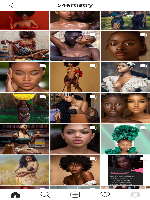

In [245]:
# 54artistry.jpg, _wildundwunderbar_.jpg
from keras.preprocessing import image

img1=image.load_img(f'Dataset/54artistry.jpg',target_size=(200,150))

Z = image.img_to_array(img1)
Z = np.expand_dims((Z),axis=0)
image = np.vstack([Z])
pred= model_tr3.predict([image])
max_pred=max(pred).argmax()
print(folders[max_pred])
img1

fitness


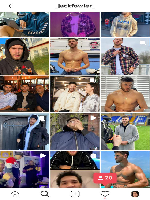

In [247]:
from keras.preprocessing import image

img2=image.load_img(f'Dataset/_jackfowler_.jpg',target_size=(200,150))

Z = image.img_to_array(img2)
Z = np.expand_dims((Z),axis=0)
image = np.vstack([Z])
pred= model_tr3.predict([image])
max_pred=max(pred).argmax()
print(folders[max_pred])
img2

food


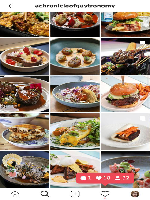

In [251]:
from keras.preprocessing import image

img3=image.load_img(f'Dataset/achronicleofgastronomy.jpg',target_size=(200,150))

Z = image.img_to_array(img3)
Z = np.expand_dims((Z),axis=0)
image = np.vstack([Z])
pred= model_tr3.predict([image])
max_pred=max(pred).argmax()
print(folders[max_pred])
img3